In [23]:
import cv2
import mediapipe as mp
import sys
import os
import time
import uuid
import math

from IPython.display import display as ipydisplay, Image, clear_output, HTML

import numpy as np
import cv2
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print('OpenCV Version: {}.{}.{}'.format(major_ver, minor_ver, subminor_ver))

import matplotlib.pyplot as plt
%matplotlib inline

import keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
print('Keras image data format: {}'.format(K.image_data_format()))

OpenCV Version: 4.4.0
Keras image data format: channels_last


In [2]:

class handDetector():
    def __init__(self, mode=False, maxHands=2, detectionCon=0.5, trackCon=0.5):
        self.mode = mode
        self.maxHands = maxHands
        self.detectionCon = detectionCon
        self.trackCon = trackCon

        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(self.mode, self.maxHands,
                                        self.detectionCon, self.trackCon)
        self.mpDraw = mp.solutions.drawing_utils
        self.tipIds = [4, 8, 12, 16, 20]

    def findHands(self, img, draw=True):
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.hands.process(imgRGB)

        if self.results.multi_hand_landmarks:
            for handLms in self.results.multi_hand_landmarks:
                if draw:
                    self.mpDraw.draw_landmarks(img, handLms,
                                               self.mpHands.HAND_CONNECTIONS)
        return img

    def findPosition(self, img, handNo=0, draw=True):
        xList = []
        yList = []
        bbox = []
        self.lmList = []
        if self.results.multi_hand_landmarks:
            myHand = self.results.multi_hand_landmarks[handNo]
            for id, lm in enumerate(myHand.landmark):
                h, w, c = img.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                xList.append(cx)
                yList.append(cy)
                self.lmList.append([id, cx, cy])
                if draw:
                    cv2.circle(img, (cx, cy), 5, (255, 0, 255), cv2.FILLED)
            xmin, xmax = min(xList), max(xList)
            ymin, ymax = min(yList), max(yList)
            bbox = xmin, ymin, xmax, ymax

            if draw:
                cv2.rectangle(img, (bbox[0] - 20, bbox[1] - 20),
                              (bbox[2] + 20, bbox[3] + 20), (0, 255, 0), 2)

        return self.lmList

    def fingersUp(self):
        fingers = []
        # Thumb
        if self.lmList[self.tipIds[0]][1] > self.lmList[self.tipIds[0] - 1][1]:
            fingers.append(1)
        else:
            fingers.append(0)

        for id in range(1, 5):
            if self.lmList[self.tipIds[id]][2] < self.lmList[self.tipIds[id] - 2][2]:
                fingers.append(1)
            else:
                fingers.append(0)
        return fingers

    def findDistance(self, p1, p2, img, draw=True):

        x1, y1 = self.lmList[p1][1], self.lmList[p1][2]
        x2, y2 = self.lmList[p2][1], self.lmList[p2][2]
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

        if draw:
            cv2.circle(img, (x1, y1), 15, (255, 0, 255), cv2.FILLED)
            cv2.circle(img, (x2, y2), 15, (255, 0, 255), cv2.FILLED)
            cv2.line(img, (x1, y1), (x2, y2), (255, 0, 255), 3)
            cv2.circle(img, (cx, cy), 15, (255, 0, 255), cv2.FILLED)

        length = math.hypot(x2 - x1, y2 - y1)
        return length, img, [x1, y1, x2, y2, cx, cy]




In [3]:
IMAGES_FOLDER = os.path.join('C:/Users/HP/Desktop/Computer-Vision-Basics-with-Python-Keras-and-OpenCV-master/images')
MODEL_PATH = os.path.join('C:/Users/HP/Desktop/Computer-Vision-Basics-with-Python-Keras-and-OpenCV-master/model')
MODEL_FILE = os.path.join(MODEL_PATH, 'C:/Users/HP/Desktop/Computer-Vision-Basics-with-Python-Keras-and-OpenCV-master/model/hand_model_gray.hdf5') # path to model weights and architechture file
MODEL_HISTORY = os.path.join(MODEL_PATH, 'C:/Users/HP/Desktop/Computer-Vision-Basics-with-Python-Keras-and-OpenCV-master/model/model_history.txt') # path to model training history

In [4]:
def bgrtorgb(image):
    return cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

In [5]:

def show_image(name):
    """
    Showing image files.
    """
    fname = os.path.join(IMAGES_FOLDER, name)
    ipydisplay(Image(fname))

In [6]:
def plot_image(image, figsize=(8,8), recolour=False):
    """
    Plotting image matricies.
    """
    if recolour: image = bgrtorgb(image)
    plt.figure(figsize=figsize)
    if image.shape[-1] == 3:
        plt.imshow(image)
    elif image.shape[-1] == 1 or len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        raise Exception("Image has invalid shape.")


In [7]:
import cv2
video = cv2.VideoCapture(0)

while True:
    success, frame = video.read()
    if not success:
        break
        

    cv2.imshow("frame", frame)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27:
        break
    elif k == 115:
        fname = input("File name")
        cv2.imwrite(os.path.join(IMAGES_FOLDER, '{}.jpg'.format(fname)), frame)
        
cv2.destroyAllWindows()
video.release()

Image Shape:  (194, 259, 3) 


Image Matrix: 
 [[[119 158 155]
  [119 158 155]
  [119 158 155]
  ...
  [122 158 156]
  [120 159 156]
  [120 159 156]]

 [[119 158 155]
  [119 158 155]
  [120 159 156]
  ...
  [122 158 156]
  [120 159 156]
  [120 159 156]]

 [[120 159 156]
  [120 159 156]
  [120 159 156]
  ...
  [123 159 157]
  [121 160 157]
  [121 160 157]]

 ...

 [[103 145 141]
  [104 146 142]
  [104 146 142]
  ...
  [209 186 172]
  [211 185 172]
  [211 185 172]]

 [[102 144 140]
  [103 145 141]
  [103 145 141]
  ...
  [211 187 175]
  [211 187 175]
  [211 187 175]]

 [[102 144 140]
  [103 145 141]
  [103 145 141]
  ...
  [210 188 175]
  [211 187 175]
  [211 187 175]]] 


Image Plotted:


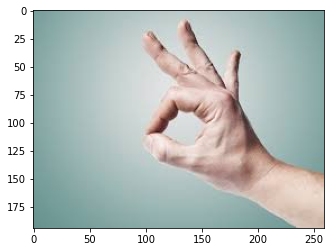

In [10]:
hand_fname = os.path.join(IMAGES_FOLDER, 'hand.jpg')
hand_img = cv2.imread(hand_fname)

hand_img = cv2.cvtColor(hand_img, cv2.COLOR_BGR2RGB)
plt.imshow(hand_img)

print('Image Shape: ', hand_img.shape, '\n\n')
print('Image Matrix: \n', hand_img, '\n\n')
print('Image Plotted:')

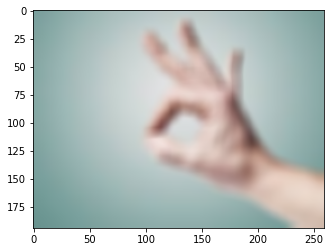

In [11]:
blur_img = hand_img.copy()
blur_img = cv2.GaussianBlur(blur_img, (11, 11), 10)
plt.imshow(blur_img)

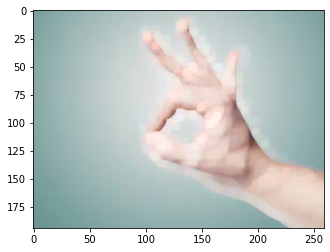

In [12]:
dilate_img = hand_img.copy()
dilate_img = cv2.dilate(dilate_img, np.ones((6,6), dtype=np.uint8), iterations=1)
plt.imshow(dilate_img)

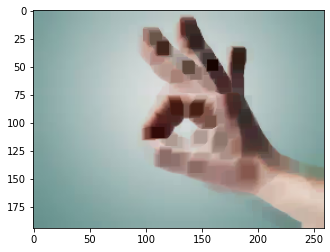

In [13]:
erosion_img = hand_img.copy()
erosion_img = cv2.erode(erosion_img, np.ones((10,10), dtype=np.uint8), iterations=1)
plt.imshow(erosion_img)

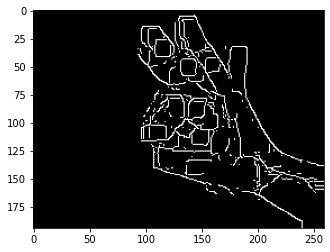

In [14]:

canny_img = hand_img.copy()
canny_img = cv2.erode(canny_img, np.ones((12,12), dtype=np.uint8), iterations=1)
thresh = 75
edges = cv2.Canny(canny_img,thresh,thresh)
plt.imshow(edges.astype(np.uint8), cmap='gray')

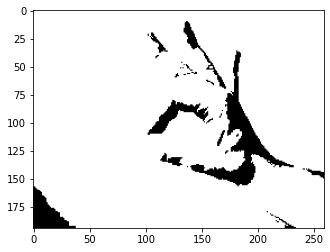

In [15]:
thresh_img = hand_img.copy()
thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(thresh_img, 150, 250, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')

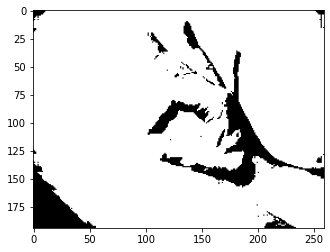

In [16]:
thresh_img = hand_img.copy()
thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(thresh_img, 155, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')

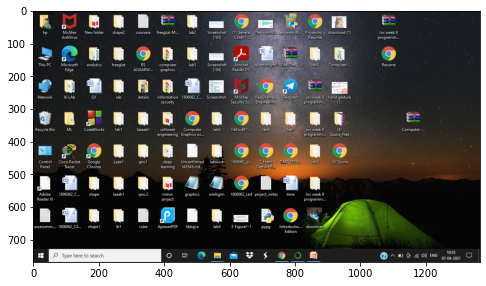

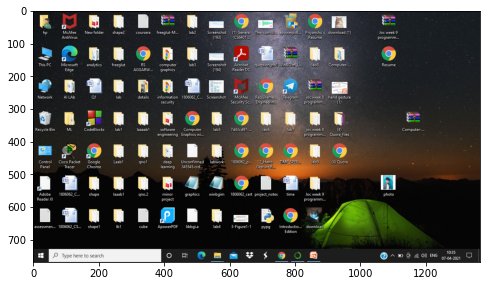

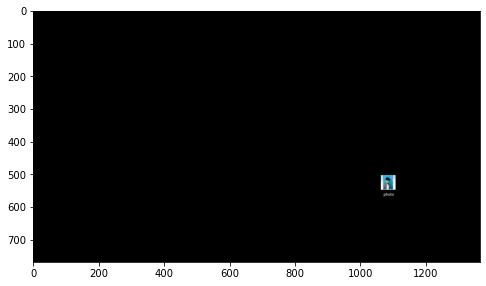

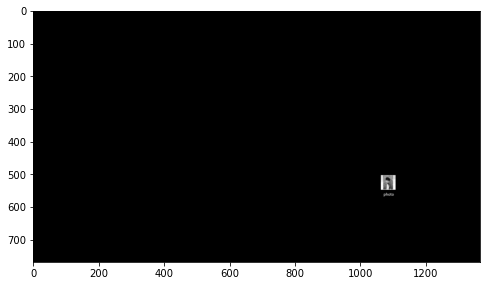

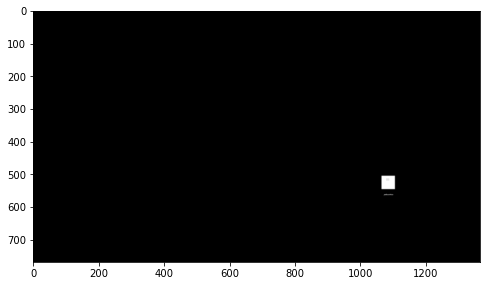

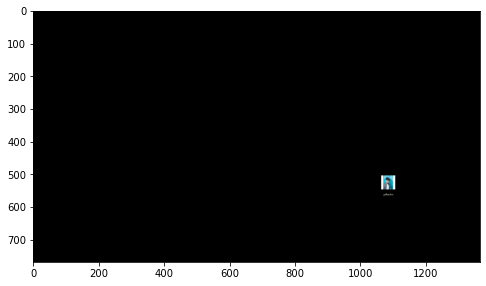

In [18]:

bg_img = cv2.imread(os.path.join(IMAGES_FOLDER, 'gg2.png'))
current_frame_img = cv2.imread(os.path.join(IMAGES_FOLDER, 'gg1.png'))

diff = cv2.absdiff(bg_img, current_frame_img)
mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
th, mask_thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
mask_blur = cv2.GaussianBlur(mask_thresh, (3, 3), 10)
mask_erosion = cv2.erode(mask_blur, np.ones((5,5), dtype=np.uint8), iterations=1)

mask_indexes = mask_erosion > 0

foreground = np.zeros_like(current_frame_img, dtype=np.uint8)
for i, row in enumerate(mask_indexes):
    foreground[i, row] = current_frame_img[i, row]

plot_image(bg_img, recolour=True)
plot_image(current_frame_img, recolour=True)
plot_image(diff, recolour=True)
plot_image(mask)
plot_image(mask_erosion)
plot_image(foreground, recolour=True)

In [3]:
def main():
    pTime = 0
    cap = cv2.VideoCapture(0)
    detector = handDetector()
    while True:
        success, img = cap.read()
        img = detector.findHands(img)
        lmList = detector.findPosition(img)
        if len(lmList) != 0:
            print(lmList[4])
        cTime = time.time()
        fps = 1 / (cTime - pTime)
        pTime = cTime

        cv2.putText(img, str(int(fps)), (10, 70), cv2.FONT_HERSHEY_PLAIN, 3,
                    (255, 0, 255), 3)

        cv2.imshow("Image", img)
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break
    cv2.destroyAllWindows()
    cap.release()

if __name__ == "__main__":
    main()

[4, 235, 123]
[4, 397, 187]
[4, 390, 185]
[4, 379, 177]
[4, 297, 274]
[4, 295, 276]
[4, 319, 237]
[4, 330, 214]
[4, 328, 209]
[4, 340, 207]
[4, 338, 205]
[4, 344, 206]
[4, 343, 206]
[4, 351, 211]
[4, 353, 211]
[4, 356, 216]
[4, 356, 216]
[4, 358, 217]
[4, 351, 213]
[4, 351, 212]
[4, 296, 219]
[4, 294, 219]
[4, 269, 206]
[4, 272, 210]
[4, 273, 216]
[4, 300, 215]
[4, 341, 222]
[4, 339, 228]
[4, 379, 244]
[4, 377, 250]
[4, 382, 250]
[4, 385, 254]
[4, 387, 253]
[4, 388, 249]
[4, 387, 254]
[4, 386, 253]
[4, 384, 253]
[4, 384, 255]
[4, 385, 256]
[4, 381, 253]
[4, 381, 254]
[4, 375, 246]
[4, 372, 246]
[4, 283, 228]
[4, 287, 228]
[4, 273, 221]
[4, 271, 223]
[4, 266, 218]
[4, 263, 215]
[4, 241, 195]
[4, 216, 197]
[4, 215, 201]
[4, 225, 201]
[4, 230, 220]
[4, 229, 217]
[4, 231, 220]
[4, 243, 217]
[4, 229, 220]
[4, 238, 223]
[4, 236, 217]
[4, 240, 215]
[4, 223, 214]
[4, 237, 216]
[4, 249, 234]
[4, 250, 242]
[4, 259, 241]
[4, 259, 233]
[4, 250, 235]
[4, 253, 236]
[4, 264, 247]
[4, 265, 247]
[4, 25

In [19]:

ERODE = True

fgbg = cv2.createBackgroundSubtractorMOG2()

video = cv2.VideoCapture(0)
while True:
    time.sleep(0.025)
    
    timer = cv2.getTickCount()
    
    success, frame = video.read()
    if not success:
        break
        
    fgmask = fgbg.apply(frame)
    
    # Apply erosion to clean up noise
    if ERODE:
        fgmask = cv2.erode(fgmask, np.ones((3,3), dtype=np.uint8), iterations=1)
    
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    cv2.putText(fgmask, "FPS : " + str(int(fps)), (100, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
 
    cv2.imshow("fgmask", fgmask)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break
        
cv2.destroyAllWindows()
video.release()

In [20]:
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'MOSSE']
    tracker_type = tracker_types[ttype]
    
    if tracker_type == 'BOOSTING':
        tracker = cv2.TrackerBoosting_create()
    if tracker_type == 'MIL':
        tracker = cv2.TrackerMIL_create()
    if tracker_type == 'KCF':
        tracker = cv2.TrackerKCF_create()
    if tracker_type == 'TLD':
        tracker = cv2.TrackerTLD_create()
    if tracker_type == 'MEDIANFLOW':
        tracker = cv2.TrackerMedianFlow_create()
    if tracker_type == 'MOSSE':
        tracker = cv2.TrackerMOSSE_create()
    
    return tracker

In [21]:
video = cv2.VideoCapture(0)

success, frame = video.read()
if not success:
    print("first frame not read")
    sys.exit()

tracker = setup_tracker(4)

bbox = cv2.selectROI(frame, False)
cv2.destroyAllWindows()


tracking_success = tracker.init(frame, bbox)

while True:
    time.sleep(0.02)
    
    timer = cv2.getTickCount()
    
    success, frame = video.read()
    if not success:
        break
        
   
    tracking_success, bbox = tracker.update(frame)
    
   
    if tracking_success:
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)        
    else:
        cv2.putText(frame, "Tracking failure detected", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    cv2.putText(frame, "FPS : " + str(int(fps)), (100, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 0, 0), 2)
    
    cv2.imshow("frame", frame)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break 
        
cv2.destroyAllWindows()
video.release()

In [24]:
test_model = Sequential()

test_model.add(Dense(2, input_shape=(2,), activation='relu'))
test_model.add(Dense(32, activation='relu'))
test_model.add(Dense(32, activation='relu'))
test_model.add(Dense(1, activation='relu'))

test_model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
test_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,191
Trainable params: 1,191
Non-trainable params: 0
_________________________________________________________________


In [26]:
def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
bg = frame.copy()


kernel = np.ones((3,3),np.uint8)

    
while True:
    ok, frame = video.read()
    if not ok:
        break
        
        
    timer = cv2.getTickCount()

    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
   
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Get mask indexes
    imask = img_dilation > 0
    # Get foreground from mask
    foreground = mask_array(frame, imask)
    
    
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    cv2.putText(frame, "FPS : " + str(int(fps)), (100, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    cv2.imshow("frame", frame)
    cv2.imshow("diff", diff)
    cv2.imshow("thresh", thresh)
    cv2.imshow("img_dilation", img_dilation)
    cv2.imshow("foreground", foreground)
    
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break 
    elif k == 114 or k == 112: 
        # r pressed
        bg = frame.copy()
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

In [40]:
cv2.destroyAllWindows()
video.release()

In [41]:

def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


# Read first frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()

bg = frame.copy()


# Kernel for erosion and dilation of masks
kernel = np.ones((3,3),np.uint8)


bbox_initial = (60, 60, 170, 170)
bbox = bbox_initial
tracking = -1


positions = {
    'fps': (15, 20)
}

   
while True:
    ok, frame = video.read()
    display = frame.copy()
    if not ok:
        break
        
        
    timer = cv2.getTickCount()

    
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)

    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)

    imask = img_dilation > 0

    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    

    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        
    hand_crop = frame[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    
        
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    

    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    cv2.imshow("display", display)

    cv2.imshow("diff", diff)
    cv2.imshow("thresh", thresh)

    cv2.imshow("img_dilation", img_dilation)
    try:
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 112: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        fname = os.path.join("data", CURR_POS, "{}_{}.jpg".format(CURR_POS, get_unique_name(os.path.join("data", CURR_POS))))
        cv2.imwrite(fname, hand_crop)
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

In [18]:

classes = {
    0: 'fist',
    1: 'five',
    2: 'point',
    3: 'swing'
}

CURR_POSE = 'swing'
DATA = 'C:/Users/hp'

def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


# Begin capturing video
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


# Read first frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
# Use the first frame as an initial background frame
bg = frame.copy()


# Kernel for erosion and dilation of masks
kernel = np.ones((3,3),np.uint8)


bbox_initial = (60, 60, 170, 170)
bbox = bbox_initial

tracking = -1


positions = {
    'hand_pose': (15, 40),
    'fps': (15, 20)
}


# Image count for file name
img_count = 0

# Capture, process, display loop    
while True:
    # Read a new frame
    ok, frame = video.read()
    display = frame.copy()
    if not ok:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    # Threshold the mask
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Get mask indexes
    imask = img_dilation > 0
    # Get foreground from mask
    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    
    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
    hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    
        
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
        
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("display", display)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Display hand_crop
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Display foreground_display
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 112: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        img_count += 1
        fname = os.path.join(DATA, 'Desktop', "{}_{}.jpg".format(CURR_POSE, img_count))
        cv2.imwrite(fname, hand_crop)
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

In [42]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(54, 54, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
"""batch_size = 16

training_datagen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=10)

training_generator = training_datagen.flow_from_directory(
    'training_data',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(
    'validation_data',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale'
)"""

In [ ]:
"""
model.fit_generator(
    generator=training_generator,
    steps_per_epoch=2000 // batch_size,
    epochs=50,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=200 // batch_size,
    workers=8,
)
"""

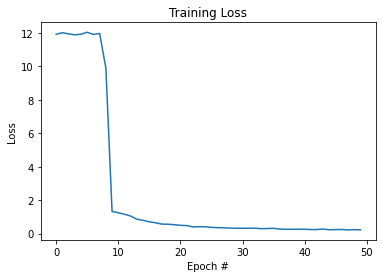

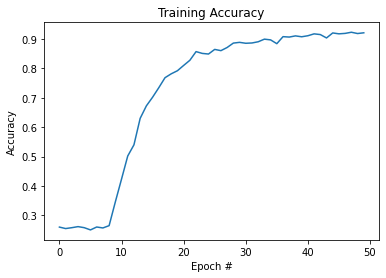

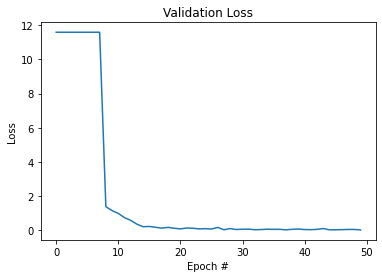

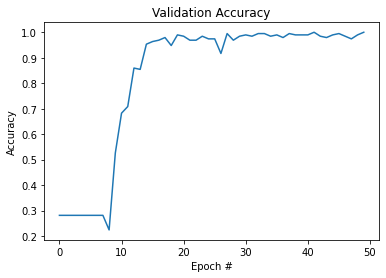

In [53]:
import re
with open(MODEL_HISTORY) as history_file:
    history = history_file.read()

data = {}

data['acc'] = re.findall(' acc: ([0-9]+\.[0-9]+)', history)
data['loss'] = re.findall(' loss: ([0-9]+\.[0-9]+)', history)
data['val_acc'] = re.findall(' val_acc: ([0-9]+\.[0-9]+)', history)
data['val_loss'] = re.findall(' val_loss: ([0-9]+\.[0-9]+)', history)

for key, values in data.items():
    for i, val in enumerate(values):
        values[i] = float(val)

plt.figure()
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['loss'])


plt.figure()
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['acc'])


plt.figure()
plt.title("Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['val_loss'])


plt.figure()
plt.title("Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['val_acc'])

In [ ]:
# model.save("hand_model_gray.hdf5")

In [43]:
hand_model = load_model(MODEL_FILE, compile=False)

In [46]:
classes = {
    0: 'fist',
    1: 'five',
    2: 'point',
    3: 'swing'
}

# Set up tracker.
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if int(minor_ver) < 3:
        tracker = cv2.Tracker_create(tracker_type)
    else:
        if tracker_type == 'BOOSTING':
            tracker = cv2.TrackerBoosting_create()
        if tracker_type == 'MIL':
            tracker = cv2.TrackerMIL_create()
        if tracker_type == 'KCF':
            tracker = cv2.TrackerKCF_create()
        if tracker_type == 'TLD':
            tracker = cv2.TrackerTLD_create()
        if tracker_type == 'MEDIANFLOW':
            tracker = cv2.TrackerMedianFlow_create()
        if tracker_type == 'GOTURN':
            tracker = cv2.TrackerGOTURN_create()
    
    return tracker

def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output



video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()

bg = frame.copy()


kernel = np.ones((3,3),np.uint8)

positions = {
    'hand_pose': (15, 40),
    'fps': (15, 20),
    'null_pos': (200, 200)
}


bbox_initial = (116, 116, 170, 170)
bbox = bbox_initial
tracking = -1

    
while True:
    ok, frame = video.read()
    display = frame.copy()
    data_display = np.zeros_like(display, dtype=np.uint8)
    if not ok:
        break
        
        
    timer = cv2.getTickCount()

    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    imask = img_dilation > 0
    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    

    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        
    hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    try:
        hand_crop_resized = np.expand_dims(cv2.resize(hand_crop, (54, 54)), axis=0).reshape((1, 54, 54, 1))
        prediction = hand_model.predict(hand_crop_resized)
        predi = prediction[0].argmax() 
        gesture = classes[predi]
        
        for i, pred in enumerate(prediction[0]):
            barx = positions['hand_pose'][0]
            bary = 60 + i*60
            bar_height = 20
            bar_length = int(400 * pred) + barx 
        
            if i == predi:
                colour = (0, 255, 0)
            else:
                colour = (0, 0, 255)
            
            cv2.putText(data_display, "{}: {}".format(classes[i], pred), (positions['hand_pose'][0], 30 + i*60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)
            cv2.rectangle(data_display, (barx, bary), (bar_length, bary - bar_height), colour, -1, 1)
        
        cv2.putText(display, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(foreground_display, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    except Exception as ex:
        cv2.putText(display, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(foreground_display, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    
        
    # Draw bounding box
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
    
    # Move the mouse
    hand_pos = ((p1[0] + p2[0])//2, (p1[1] + p2[1])//2)
    mouse_change = ((p1[0] + p2[0])//2 - positions['null_pos'][0], positions['null_pos'][0] - (p1[1] + p2[1])//2)
    # Draw mouse points
    cv2.circle(display, positions['null_pos'], 5, (0,0,255), -1)
    cv2.circle(display, hand_pos, 5, (0,255,0), -1)
    cv2.line(display,positions['null_pos'],hand_pos,(255,0,0),5)
    
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("display", display)
    # Display result
    cv2.imshow("data", data_display)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Display hand_crop
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Display foreground_display
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 108: 
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        fname = os.path.join("data", CURR_POS, "{}_{}.jpg".format(CURR_POS, get_unique_name(os.path.join("data", CURR_POS))))
        cv2.imwrite(fname, hand_crop)
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

In [ ]:
import cv2
import time
import numpy as np
import math
from ctypes import cast, POINTER
from comtypes import CLSCTX_ALL
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume
wCam, hCam = 640, 480


cap = cv2.VideoCapture(0)
cap.set(3, wCam)
cap.set(4, hCam)
pTime = 0

detector =handDetector(detectionCon=0.7)

devices = AudioUtilities.GetSpeakers()
interface = devices.Activate(
    IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
volume = cast(interface, POINTER(IAudioEndpointVolume))
# volume.GetMute()
# volume.GetMasterVolumeLevel()
volRange = volume.GetVolumeRange()
minVol = volRange[0]
maxVol = volRange[1]
vol = 0
volBar = 400
volPer = 0
while True:
    success, img = cap.read()
    img = detector.findHands(img)
    lmList = detector.findPosition(img, draw=False)
    if len(lmList) != 0:
        # print(lmList[4], lmList[8])

        x1, y1 = lmList[4][1], lmList[4][2]
        x2, y2 = lmList[8][1], lmList[8][2]
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

        cv2.circle(img, (x1, y1), 15, (255, 0, 255), cv2.FILLED)
        cv2.circle(img, (x2, y2), 15, (255, 0, 255), cv2.FILLED)
        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 255), 3)
        cv2.circle(img, (cx, cy), 15, (255, 0, 255), cv2.FILLED)

        length = math.hypot(x2 - x1, y2 - y1)

        # Hand range 50 - 300
        # Volume Range -65 - 0

        vol = np.interp(length, [50, 300], [minVol, maxVol])
        volBar = np.interp(length, [50, 300], [400, 150])
        volPer = np.interp(length, [50, 300], [0, 100])
        print(int(length), vol)
        volume.SetMasterVolumeLevel(vol, None)

        if length < 50:
            cv2.circle(img, (cx, cy), 15, (0, 255, 0), cv2.FILLED)

    cv2.rectangle(img, (50, 150), (85, 400), (255, 0, 0), 3)
    cv2.rectangle(img, (50, int(volBar)), (85, 400), (255, 0, 0), cv2.FILLED)
    cv2.putText(img, f'{int(volPer)} %', (40, 450), cv2.FONT_HERSHEY_COMPLEX,
                1, (255, 0, 0), 3)


    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    cv2.putText(img, f'FPS: {int(fps)}', (40, 50), cv2.FONT_HERSHEY_COMPLEX,
                1, (255, 0, 0), 3)

    cv2.imshow("Img", img)
    k = cv2.waitKey(1) & 0xff
    if k == 27:
        break
cv2.destroyAllWindows()
cap.release()
    